In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import torch

from model import *

In [3]:
sns.set(style='darkgrid')
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(42)

# Load Data

In [25]:
# Fake data
num_mentors = 200
num_mentees = 500
num_matches = 450
num_features = 20
num_truth = 100

# Generate underlying features
mentee_truth = np.random.rand(num_mentees, num_truth)
mentor_truth = np.random.rand(num_mentors, num_truth)

# Transform into survey features
feature_transform = np.random.rand(num_truth, num_features)
mentee_features = mentee_truth @ feature_transform
mentor_features = mentor_truth @ feature_transform

# Generate matches and match quality
matches_mentees = np.random.choice(range(num_mentees), num_matches, replace=False)
matches_mentors = np.random.choice(range(num_mentors), num_matches, replace=True)
matches = np.stack((matches_mentees, matches_mentors), axis=1)
matches_outcome = np.array([
    np.sum(mentee_truth[id1] * mentor_truth[id2])
    / (np.linalg.norm(mentee_truth[id1]) * np.linalg.norm(mentor_truth[id2]))
    for id1, id2 in matches])

# Binarize positives (optional)
matches_outcome = 1 * (matches_outcome > -1)

# Implement fake negatives (optional)
fake_percentage = .5
fake_num = int(fake_percentage * num_matches / (1 - fake_percentage))
fake_mentees = np.random.choice(range(num_mentees), fake_num, replace=True)
fake_mentors = np.random.choice(range(num_mentors), fake_num, replace=True)
fake_matches = np.stack((fake_mentees, fake_mentors), axis=1)
fake_outcome = np.zeros(fake_num)
# Append
matches = np.concatenate((matches, fake_matches), axis=0)
matches_outcome = np.concatenate((matches_outcome, fake_outcome), axis=0)
# mentee_features
feature_ids = np.array(range(len(mentee_features)))
mentees = np.array(range(num_mentees))
mentors = np.array(range(num_mentors))

In [27]:
# Train-Test
train_idx = range(int(.8 * len(mentees)))
test_idx = list(set(range(len(mentees))) - set(train_idx))
sort_idx = np.argsort(feature_ids)  # TODO, Further shuffle matches
mentee_features, mentee_features_test = mentee_features[sort_idx][train_idx], mentee_features[sort_idx][test_idx]
feature_ids, feature_ids_test = feature_ids[sort_idx][train_idx], feature_ids[sort_idx][test_idx]
idx = [(mentee in feature_ids) for mentee in matches[:, 0]]
tidx = [(mentee in feature_ids_test) for mentee in matches[:, 0]]
matches, matches_test = matches[idx], matches[tidx]
matches_outcome, matches_outcome_test = matches_outcome[idx], matches_outcome[tidx]
# Finalize dim variables
num_mentors = len(mentors)
num_mentees = len(train_idx)
num_matches = len(matches)
num_features = mentee_features.shape[1]
num_mentors_test = len(mentors)
num_mentees_test = len(test_idx)
num_matches_test = len(matches_test)
num_features_test = mentee_features.shape[1]

# Implement fake negatives (optional)
fake_percentage = .5
fake_num = int(fake_percentage * num_matches / (1 - fake_percentage))
fake_mentees = np.random.choice(range(num_mentees), fake_num, replace=True)
fake_mentors = np.random.choice(range(num_mentors), fake_num, replace=True)
fake_matches = np.stack((fake_mentees, fake_mentors), axis=1)
fake_outcome = np.zeros(fake_num)
# Append
matches = np.concatenate((matches, fake_matches), axis=0)
matches_outcome = np.concatenate((matches_outcome, fake_outcome), axis=0)
num_matches = len(matches)

# Cast to type
matches = torch.Tensor(matches.astype(float)).int()
matches_outcome = torch.Tensor(matches_outcome).float()
matches_test = torch.Tensor(matches_test.astype(float)).int()
matches_outcome_test = torch.Tensor(matches_outcome_test).float()
mentee_features = torch.Tensor(mentee_features).float()
mentee_features_test = torch.Tensor(mentee_features_test).float()

# Adversarial Model

In [28]:
# User Variables
dim_embedding = 10
epochs = 10001
batches = 20
lr = .001
epoch_pd = 2000
batch_size = 64
batches = int(len(matches)/batch_size)

# Generator Model
gen_model = EmbeddingGenerationModel(num_mentees, num_mentors, dim=dim_embedding)
gen_optimizer = torch.optim.AdamW(gen_model.parameters(), lr=lr)
gen_criterion = nn.MSELoss()

# Inference Model
inf_model = EmbeddingInferenceModel(num_features, dim=dim_embedding)
inf_optimizer = torch.optim.AdamW(inf_model.parameters(), lr=lr)
inf_criterion = nn.MSELoss()

# Adversarial Criterion
adv_criterion = nn.MSELoss()

In [29]:
gen_model.train()
inf_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        loss = 0
        
        # Train embeddings
        gen_optimizer.zero_grad()
        gen_idx = np.random.choice(range(len(matches)), batch_size, replace=False)
        gen_input_data = torch.t(matches[gen_idx])
        gen_logits = gen_model(*gen_input_data)
        gen_loss = gen_criterion(gen_logits, matches_outcome[gen_idx])
        gen_loss.backward()
        gen_optimizer.step()
        
        # Train survey features
        inf_optimizer.zero_grad()
        inf_idx = np.unique(matches[gen_idx, 0])
        inf_input_data = mentee_features[inf_idx]
        inf_logits = inf_model(inf_input_data)
        inf_true = gen_model.mentees(torch.Tensor(inf_idx).int()).detach()
        inf_loss = inf_criterion(inf_logits, inf_true)
        inf_loss.backward()
        inf_optimizer.step()
        
        # Adversarial loss
        gen_optimizer.zero_grad()
        inf_optimizer.zero_grad()
        adv_loss = adv_criterion(inf_model(inf_input_data), gen_model.mentees(torch.Tensor(inf_idx).int()))
        adv_loss.backward()
        gen_optimizer.step()
        inf_optimizer.step()
        
    if epoch % epoch_pd == 0:
        print(f'Epoch: {epoch}', end=' \t')
        print(f'Generator Loss: {float(gen_loss)}', end=' \t')
        print(f'Inference Loss: {float(inf_loss)}', end=' \t')
        print(f'Adversarial Loss: {float(adv_loss)}')
gen_model.eval();

Epoch: 0 	Generator Loss: 0.3110804855823517 	Inference Loss: 1.864976406097412 	Adversarial Loss: 1.86080002784729
Epoch: 2000 	Generator Loss: 0.0006913416436873376 	Inference Loss: 0.0008866156567819417 	Adversarial Loss: 0.0008848606375977397
Epoch: 4000 	Generator Loss: 0.0006768224993720651 	Inference Loss: 0.0006626325193792582 	Adversarial Loss: 0.0006623445660807192
Epoch: 6000 	Generator Loss: 0.0005186801427043974 	Inference Loss: 0.0007416929583996534 	Adversarial Loss: 0.0007408801466226578
Epoch: 8000 	Generator Loss: 0.0007729498902335763 	Inference Loss: 0.0007329962099902332 	Adversarial Loss: 0.0007292955415323377
Epoch: 10000 	Generator Loss: 0.0051154522225260735 	Inference Loss: 0.0007552547031082213 	Adversarial Loss: 0.0007559709483757615


## Visualization

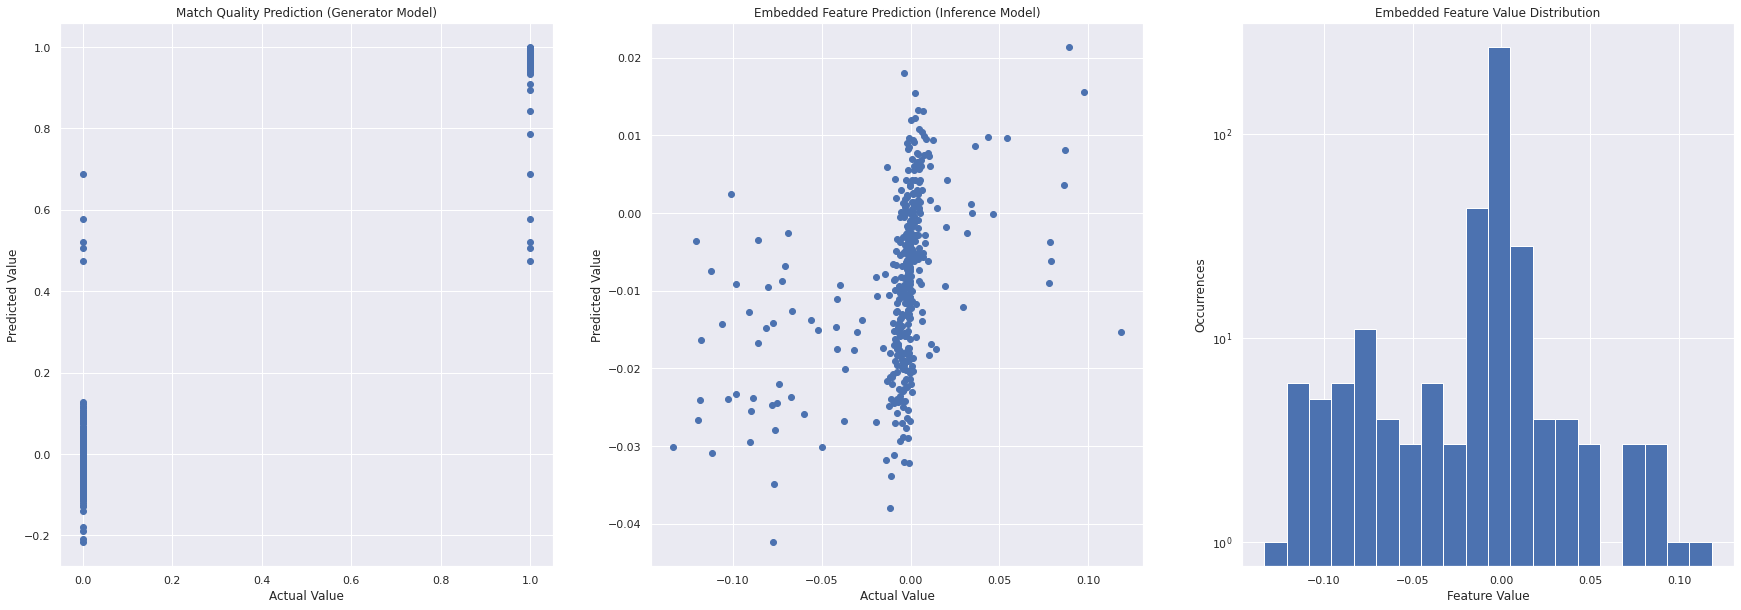

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

# Plot embedding accuracy
plt.sca(axs[0])
predicted = gen_model(*torch.t(matches)).detach().cpu().numpy()
actual = matches_outcome
feat_test = inf_model(mentee_features_test[matches_test[:, 0] - len(train_idx)]).detach().cpu()
predicted_test = gen_model(feat_test, matches_test[:, 1], manual_e=True).detach().cpu().numpy()
actual_test = matches_outcome_test

plt.scatter(actual, predicted)
# plt.scatter(actual_test, predicted_test)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Match Quality Prediction (Generator Model)')

# Plot survey features
plt.sca(axs[1])
feature = 0
input_data = mentee_features
predicted = inf_model(input_data).detach().cpu().numpy()
actual = gen_model.mentees(torch.Tensor(range(num_mentees)).int()).detach().cpu().numpy()
predicted, actual = predicted[:, feature], actual[:, feature]

plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Embedded Feature Prediction (Inference Model)')

# Plot histogram of survey values
plt.sca(axs[2])
plt.hist(actual, bins=20)
plt.xlabel('Feature Value')
plt.ylabel('Occurrences')
plt.title('Embedded Feature Value Distribution')
plt.gca().set_yscale('log');